#### Data Extraction
extract essential information from JSON for the analysis
"title","views", "likes","comments", 'duration','tag','description', 'channel', 'category', 'published'

In [62]:
#extracting json to df
import os, json
import pandas as pd
import numpy as np
import glob
from datetime import datetime
pd.set_option('display.max_columns', None)

dir = 'data'
path = os.path.join(dir, '**/*.json')
file_list = glob.glob(path)
print('Total number of channels ' + str(len(file_list)))
# print(file_list)
dfs = list()

for file in file_list:
    with open(file, 'r') as f:
        data = json.load(f)
    channel_id, stats = data.popitem()
    pchannel_stats = stats["channel_statistics"]
    video_stats = stats["video_data"]
    # sorted_vids = sorted(video_stats.items(), key=lambda item: int(item[1]["viewCount"]),reverse=True)
    vids = video_stats.items()
    stats = []
    for vid in vids:
        video_id = vid[0]
        title = vid[1]["title"]
        try:
            views = vid[1]["viewCount"]
            likes = vid[1]["likeCount"]
            duration = vid[1]['duration']
            tags = vid[1]['tags']
            description = vid[1]['description']
            comments = vid[1]["commentCount"]
            channel = vid[1]['channelTitle']
            published = vid[1]['publishedAt'].split('T')[0]
        except:
            pass
        cat = os.path.dirname(file).split('\\')[1]
        stats.append([title,views, published, likes, comments, duration, tags, description, channel, cat])
    vid_df = pd.DataFrame(stats, columns=["title","views", 'published',"likes","comments", 'duration','tag','description', 'channel', 'category'])
    dfs.append(vid_df)
df = pd.concat(dfs, ignore_index=True)
print('Total number of videos ' + str(df.shape[0]))


Total number of channels 116
Total number of videos 44695


Data Cleaning

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44695 entries, 0 to 44694
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        44695 non-null  object
 1   views        44695 non-null  object
 2   published    44695 non-null  object
 3   likes        44695 non-null  object
 4   comments     44695 non-null  object
 5   duration     44695 non-null  object
 6   tag          44695 non-null  object
 7   description  44695 non-null  object
 8   channel      44695 non-null  object
 9   category     44695 non-null  object
dtypes: object(10)
memory usage: 3.4+ MB


In [64]:
# convert published date into datetime
df.published = pd.to_datetime(df.published, format='%Y-%m-%d')

# convert duration into minute with regex

df.sample(5)

,title,views,published,likes,comments,duration,tag,description,channel,category
21465,Perk UP Your Boobies | Chest Workout For Women,453243,2016-06-07,9373,205,PT4M9S,"[workout, free workout, free personal trainer,...","Welcome back, babes! 💜 Today I am speaking fro...",Whitney Simmons,Fitness_workout
1591,My Boyfriend Teaches Me Jiu Jitsu 3,4084720,2018-07-26,181656,16218,PT16M27S,"[jenna, marbles, mourey, my, boyfriend, teache...",Please subscribe to my channel and my vlog cha...,JennaMarbles,Comedy
2795,MY NEW PERMANENT EYEBROWS,38557969,2016-11-04,1085486,42130,PT8M21S,"[liza, lizza, lizzza, lizzzak, lizzzako, lizak...",Are we running today? Are you? Just do it! Lik...,Liza Koshy,Comedy
41505,Salute your Core - 10 minute Vinyasa yoga with...,2994,2020-04-20,107,3,PT7M26S,"[yoga, Online yoga, Online yoga classes, Yoga ...",In this short core sun salutation you connect ...,EkhartYoga,Yoga
7445,"NYC Melted Cheese feat. Burnie Burns RTX, Ian ...",220879,2017-05-09,5369,358,PT6M55S,"[raclette, food, food porn, cheese, cheesy, ch...","NYC Melted Cheese feat. Burnie Burns RTX, Ian ...",Epic Meal Time,Cooking


convert text into Word2Vec

In [65]:
import pandas as pd
import gensim.downloader as api
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# import nltk; nltk.download('popular')

We use gensim pretrained model called 'glove-wiki-gigaword-50' with the model trained on wikipedia dataset

In [66]:
# importing pretrained gensim model to convert text tokens into vector
model_wv = api.load('glove-wiki-gigaword-50')

In [67]:
# function to convert token to word vector with word2vec finding average vector for the document
# tokenize function with df series as input to give a list of list result of each title
def df_token(df_text_series):
    # set of english stopwords
    stopset = set(stopwords.words('english'))
    token_item = []
    for t in df_text_series:
        if type(t) == list:
            t = ' '.join(t)
        else:
            pass
        tokens = [word for word in word_tokenize(t.lower()) if word not in stopset]
        token_item.append(tokens)
    return token_item

def gen_word_vec(df_text_series, wordvec):
    word_vector = []
    for token in df_token(df_text_series):
        token_considered = [t for t in token if t.isalpha]
        token_vocab = [i for i in token_considered if i in wordvec.key_to_index]
        if len(token_vocab) > 0:
            word_vector.append(np.mean(wordvec[token_vocab], axis=0))
        else:
            word_vector.append(np.zeros(wordvec.vector_size))
    word_vector = np.array(word_vector)
    return word_vector

features to work with

In [68]:
title_word_vec = gen_word_vec(df.title, model_wv)
tag_word_vec = gen_word_vec(df.tag, model_wv)
desc_word_vec = gen_word_vec(df.description, model_wv)


In [69]:
# with multiple features

Reduce dimensionality using PCA

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# set data to be fitted
X = title_word_vec
# initiate PCA with 2 components
pca = PCA(n_components=2)
X_new = pca.fit_transform(X)



In [1]:
# create biplot source from https://sukhbinder.wordpress.com/2015/08/05/biplot-with-python/
def biplot(score,coeff,pcax,pcay,labels=None):
    '''
    score: projected data from PCA 
    coeff: the eigenvectors (PCs)
    
    '''
    pca1=pcax-1
    pca2=pcay-1
    xs = score[:,pca1]
    ys = score[:,pca2]
    n=score.shape[1]
    scalex = 1.0/(xs.max()- xs.min())
    scaley = 1.0/(ys.max()- ys.min())
    plt.scatter(xs*scalex,ys*scaley)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5)
        if labels is None:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
        else:
            plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xlabel("PC{}".format(pcax))
    plt.ylabel("PC{}".format(pcay))
    plt.grid()

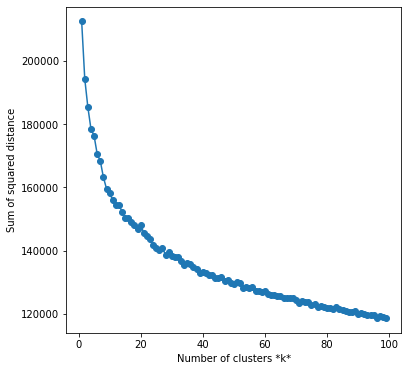

In [70]:
# Let's explore the clustering of word embadding vector using K-Means
# first let's find optimal number of cluster using elbow methods
import seaborn as sns
from sklearn.manifold import MDS
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_samples, silhouette_score
# # stardize the data in case the data are not normalized
# df_clustering = df.copy()
# X = StandardScaler().fit_transform(df_clustering.iloc[:, 1:])


# workingin title word embedding
sse=[] # sum of square error
list_k = list(range(1, 100))

for k in list_k:
    km = MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0, batch_size=2048)
    km.fit(title_word_vec)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

From the title word embedding we see no clear clustering based on the elbow method, we will try to see if the tag will produce similar results

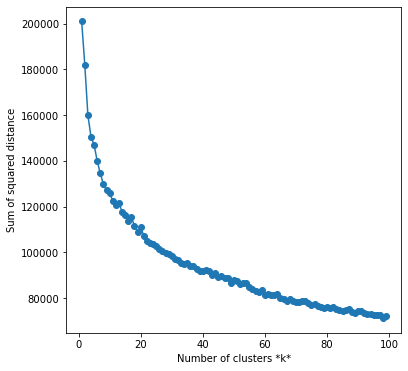

In [71]:
sse=[] # sum of square error
list_k = list(range(1, 100))

for k in list_k:
    km = MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0, batch_size=2048)
    km.fit(tag_word_vec)
    sse.append(km.inertia_)

plt.figure(figsize=(6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

We still see similar shape of sum of square error for different number of cluster on tag word embedding. Let's explore silhouette plot to examine different number of cluster.

In [72]:
# use silhouette plot based on sklearn documentation page https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
#set the dataset to be working with
X = title_word_vec

for i, k in enumerate([2, 3, 4, 5, 6]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    kmeans = MiniBatchKMeans(n_clusters=k, init='k-means++', max_iter=300, random_state=0, batch_size=2048)
    labels = kmeans.fit_predict(X)
    # centroids = kmeans.cluster_centers_

    # Get silhouette samples
    silhouette_vals = silhouette_samples(X, labels)

    # Silhouette plot
    y_ticks = []
    y_lower, y_upper = 0, 0
    for i, cluster in enumerate(np.unique(labels)):
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()
        y_upper += len(cluster_silhouette_vals)
        ax1.barh(range(y_lower, y_upper), cluster_silhouette_vals, edgecolor='none', height=1)
        ax1.text(-0.03, (y_lower + y_upper) / 2, str(i + 1))
        y_lower += len(cluster_silhouette_vals)

    # Get the average silhouette score and plot it
    avg_score = np.mean(silhouette_vals)
    ax1.axvline(avg_score, linestyle='--', linewidth=2, color='green')
    ax1.set_yticks([])
    ax1.set_xlim([-0.1, 1])
    ax1.set_xlabel('Silhouette coefficient values')
    ax1.set_ylabel('Cluster labels')
    ax1.set_title('Silhouette plot for the various clusters', y=1.02);
    
    # Use MDS to flatten the data
    embedding = MDS(n_components=2)
    mds = pd.DataFrame(embedding.fit_transform(X), columns = ['component1','component2'])
    mds['labels'] = kmeans.predict(X)

    # Scatter plot of data colored with labels
    ax2.scatter(mds['component1'], mds['component2'], c=labels)
    # ax2.scatter(centroids[:, 0], centroids[:, 1], marker='*', c='r', s=250)
    # ax2.set_xlim([-2, 2])
    # ax2.set_xlim([-2, 2])
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    ax2.set_title('Visualization of clustered data', y=1.02)
    ax2.set_aspect('equal')
    plt.tight_layout()
    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05);